<a href="https://colab.research.google.com/github/rafaeljosem/MNA-ProyectoIntegrador_EQ10/blob/main/Avance-8/Avance8_Equipo10_PEFT_%26_Inst_Fine_Tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

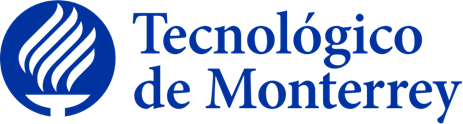

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**

### Dra. Grettel Barceló Alonso
### Dr. Luis Eduardo Falcón Morales
### Mtra. Verónica Sandra Guzmán de Valle

## **Avance 8: Creación de nuevo conjunto de datos dividiéndolo en porciones y segunda iteración de entrenamiento del modelo (Parameter Efficient and Instruction Fine Tuning)**

### Domingo 9 de junio de 2024

## **Nombres y matrículas de los integrantes del Equipo 10:**

* Fernando Maytorena Espinosa de los Monteros | A01110946
* Jonathan Garza Bennet | A01793038
* Rafael José Mateo Comprés | A01793054

# 1. Loading, reviewing and formatting the dataset <a class="anchor" id="Loading, reviewing and formatting the dataset" ></a>

In order to improved performance compared to the first instruction fine tuning model developed, a two step process will be performed to increase the domain knowledge of our model. While evaluating the first model, the resposes were not performing as expected on the allucination metrics, giving us an indication of the possibility of additional training including the knowledge from all our dataset to be required. For the last, the two step process consists on:

1. Parameter Efficient Fine Tuning (PEFT) (Xu et al., 2023) including all our Mexican Federal Laws dataset divided in portions of maximum sequence length.

2. Instruction fine tuning using an expanded version of the dataset we previously generated.

In [2]:
#Import/install required instances

import pandas as pd
from dotenv import load_dotenv
from datasets import load_dataset, concatenate_datasets, Dataset
import matplotlib.pyplot as plt
import os
import json

In [29]:
load_dotenv(override=True)

True

In [11]:
def prepare_data_for_plot(data_path: str) -> tuple[list, list]:
    with open(data_path) as f:
        training_data = json.load(f)
    

    training_loss = []
    steps = []

    for data in training_data:
        training_loss.append(data['loss'])
        steps.append(data['step'])
    
    return (steps, training_loss)
    

def plot_training_loss(data_path: str) -> None:
    steps,training_loss = prepare_data_for_plot(data_path)
    plt.plot(steps, training_loss)
    plt.title('Training Loss per 10 steps')
    plt.xlabel('Step number')
    plt.ylabel('Training loss')

    plt.show()
    

Define maximum sequence length and divide all the corpus in portions to create a new training dataset.

In [2]:
max_seq_length = 8192

Unsloth supports Llama, Mistral, Phi-3, Gemma, Yi, DeepSeek, Qwen, TinyLlama, Vicuna, Open Hermes with 16bit LoRA or 4bit QLoRA. `max_seq_length` can be set to any value, since automatic RoPE Scaling via [kaiokendev's](https://kaiokendev.github.io/til) method.

In [3]:
from unsloth import FastLanguageModel
import torch
max_seq_length = max_seq_length # Could be any since RoPE Scaling is supported.
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-v0.3-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    device_map='cuda:0'
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth: Fast Mistral patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 15.575 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


We now add LoRA adapters so only 1 to 10% of all parameters are adapted.

**According to LoRA paper (Hu et al., 2021), a good generalization is achieved with r = 64 and alfa = 16. r is related to the number of parameters on the adapter layers, computational complexity and potential overfitting. Alfa is a weighting factor in between the base model and the fine tuning adaptations.**

In [4]:
#Use Unsloth model
model = FastLanguageModel.get_peft_model(
    model,
    r = 64, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 64,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    
)

Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [5]:
model = model.to('cuda:0')
model.get_memory_footprint()/1024/1024/1024

<a name="Data"></a>
### Data Preparation

Dynamic prompt that adapts to variable number of portions per documents.

In [7]:
from datasets import load_dataset

dataset = load_dataset("JonathanGarza/legal-mx-instruction-dataset-0-6-inst-ft-prompts")
train_dataset = dataset['train']

Sanity check to make sure maximum number of tokens is not higher than maximum sequence length

In [3]:
#Function to get the maximum amount of tokens in all the dataset

def max_len_list(train_dataset):
  max_len_list = []

  for element in train_dataset:

    len_tok = len(tokenizer(element['text'])['input_ids'])

    max_len_list.append(len_tok)

  return max(max_len_list)

In [9]:
print('The maximum number of tokens in the training data is: {}'.format(max_len_list(train_dataset)))

The maximum number of tokens in the training data is: 5438


In [10]:
train_dataset[123]['text']

'A continuación se muestra una instrucción que describe una tarea, junto con un contexto que proporciona más información. Escribe una respuesta que complete adecuadamente la instrucción\n\n### Instrucción:\n¿Qué atribuciones debe tener el Director Ejecutivo de la Agencia Nacional de Seguridad Industrial y de Protección Al de acuerdo con el Artículo 27?\n\n### Contexto:\nLey de la Agencia Nacional de Seguridad Industrial y de Protección Al - Artículo 27. La Agencia estará a cargo de un Director Ejecutivo, que será designado y removido libremente por el Titular del Ejecutivo Federal. La Agencia contará con las unidades administrativas necesarias para el cumplimiento de sus atribuciones, conforme se establezca en su Reglamento Interior.\n\n### Respuesta:\nEl Director Ejecutivo de la Agencia Nacional de Seguridad Industrial y de Protección Al debe tener las atribuciones necesarias para el cumplimiento de sus funciones, las cuales deben estar establecidas en el Reglamento Interior de la Age

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer` 60 steps is default, but `num_train_epochs=1` for a full run, and turn off `max_steps=None`. TRL's are also supported with `DPOTrainer`.

1 epoch is selected for this model training evaluation.

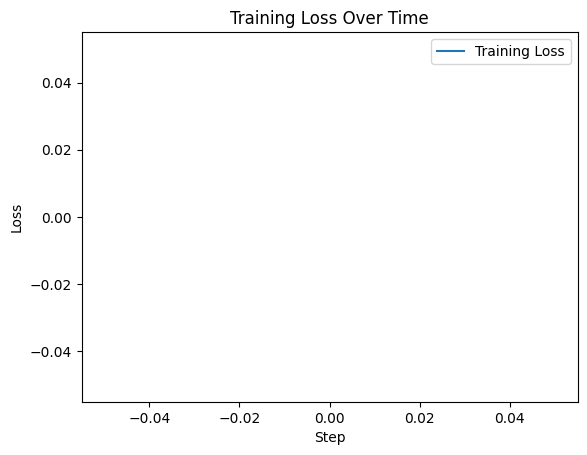

In [10]:
#Import necessary instances
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

#Train the model with all the necessary inputs
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        num_train_epochs = 1,
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        save_steps = 20,
        save_total_limit =3,
        warmup_steps = 20,
        #max_steps = 60,
        learning_rate = 2e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
      ),
    )

In [11]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 15.575 GB.
4.992 GB of memory reserved.


In [12]:
#Create a copy of the base model for reference
model_base = model

In [13]:
#Train the model
trainer_stats = trainer.train(resume_from_checkpoint = True)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 10,072 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 1,259
 "-____-"     Number of trainable parameters = 167,772,160
	save_steps: 20 (from args) != 10 (from trainer_state.json)


Step,Training Loss
30,0.866100
40,0.843400
50,0.814900
60,0.830200
70,0.771200
80,0.778100
90,0.729400
100,0.751300
110,0.765200
120,0.755500


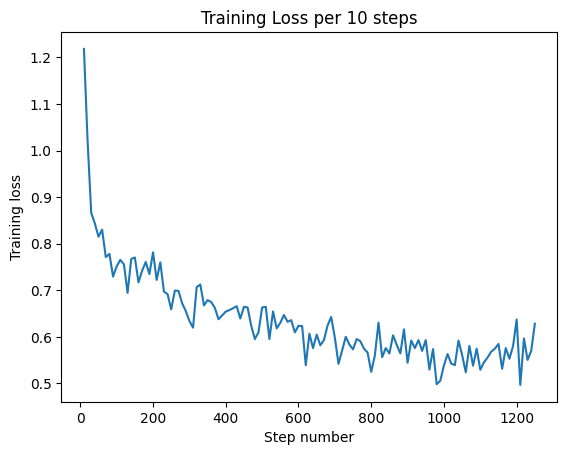

In [12]:
plot_training_loss('./outputs/training_loss_mistral_step1.json')

In [14]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

29690.3076 seconds used for training.
494.84 minutes used for training.
Peak reserved memory = 10.137 GB.
Peak reserved memory for training = 5.145 GB.
Peak reserved memory % of max memory = 65.085 %.
Peak reserved memory for training % of max memory = 33.034 %.


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

Save the first training step to be able of evaluating it.

In [31]:
#Local Save
model.save_pretrained("unsloth-mistral-0.3-7b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Instruct-FineTuned-step1") # Local saving
tokenizer.save_pretrained("unsloth-mistral-0.3-7b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Instruct-FineTuned-step1")

#HuggingFace Save
model.push_to_hub("rafaeljosem/unsloth-mistral-0.3-7b-Instruct-bnb-4bit-8k-tok-context-Mexican-Laws-Inst-FineTuned-step1", token = os.environ.get('HF_TOKEN')) # Online saving
tokenizer.push_to_hub("rafaeljosem/unsloth-mistral-0.3-7b-Instruct-bnb-4bit-8k-tok-context-Mexican-Laws-Inst-FineTuned-step1", token =os.environ.get('HF_TOKEN')) # Online saving

README.md:   0%|          | 0.00/592 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

Saved model to https://huggingface.co/rafaeljosem/unsloth-mistral-0.3-7b-Instruct-bnb-4bit-8k-tok-context-Mexican-Laws-Inst-FineTuned-step1


tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

Load the expanded intruction fine tuning data set from HuggingFace

In [32]:
#Load Mexican Federal Laws instruction fine tuning dataset

url = 'https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/Avance-8/new_set.json'

#Load it into a Pandas Dataframe
df_test = pd.read_json(url)

#Format context into a single string
for i in range(len(df_test['context'])):

  join_text = ''.join(df_test['context'][i])

  df_test['context'][i] = join_text

#Return to HF dataset in the same column order than the other datasets
dataset0 = Dataset.from_pandas(df_test[['instruction', 'output', 'context']])

#Load datasets
dataset1 = load_dataset("a01110946/legal-mx-instruction-dataset-01", split = "train")
dataset2 = load_dataset("a01110946/legal-mx-instruction-dataset-02", split = "train")
dataset3 = load_dataset("a01110946/legal-mx-instruction-dataset-03", split = "train")
dataset4 = load_dataset("a01110946/legal-mx-instruction-dataset-04", split = "train")
dataset5 = load_dataset("a01110946/legal-mx-instruction-dataset-05", split = "train")
dataset6 = load_dataset("a01110946/legal-mx-instruction-dataset-06", split = "train")

#Concatenate the datasets

dataset = concatenate_datasets([dataset0, dataset1, dataset2, dataset3, dataset4, dataset5, dataset6]).remove_columns(['task', 'legal_document', 'article'])

dataset

/tmp/ipykernel_49779/313756932.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_test['context'][i] = join_text


Generating train split:   0%|          | 0/1752 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1744 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1760 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1792 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1768 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1776 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'output', 'context'],
    num_rows: 11192
})

In [33]:
#Get dataset size
dataset.num_rows

11192

In [34]:
#Lists to save total number of tokens for all instruction, outputs and contexts
list_tokens_instruction = []
list_tokens_output = []
list_tokens_context = []
list_total_tokens = []

#Loop through dataset to count all tokens
for row in dataset:

    #print(row['instruction'])

    #Get all tokens from all rows

    #If None, total tokens is 0
    if row['instruction'] != None:
      tokens_instruction = len(tokenizer(row['instruction'])["input_ids"])
    else:
      tokens_instruction = 0

    if row['output'] != None:
      tokens_output = len(tokenizer(row['output'])["input_ids"])
    else:
      tokens_output = 0

    if row['context'] != None:
      tokens_context = len(tokenizer(row['context'])["input_ids"])
    else:
      tokens_output = 0
    #Sum all counts
    total_tokens = tokens_instruction + tokens_output + tokens_context

    #Append results to lists
    list_tokens_instruction.append(tokens_instruction)
    list_tokens_output.append(tokens_output)
    list_tokens_context.append(tokens_context)
    list_total_tokens.append(total_tokens)

In [35]:
##Print longest set of instruction, outpup and dataset
print('Longest total tokens instruction:\n\n'+ dataset['instruction'][list_total_tokens.index(max(list_total_tokens))] + '\n\n')
print('Longest total tokens output:\n\n'+ dataset['output'][list_total_tokens.index(max(list_total_tokens))] + '\n\n')
print('Longest total tokens context:\n\n'+ dataset['context'][list_total_tokens.index(max(list_total_tokens))] + '\n\n')

Longest total tokens instruction:

Compara los artículos derogados en relación con su estatus legal y fecha de derogación.


Longest total tokens output:

Los artículos derogados mencionados han sido eliminados y ya no tienen validez legal. La fecha de derogación de todos los artículos mencionados es el 16-05-2016.


Longest total tokens context:

 (Se deroga).

Artículo derogado DOF 16-05-2016

Artículo 629.- (Se deroga).

Artículo derogado DOF 16-05-2016

Artículo 630.- (Se deroga).

Artículo derogado DOF 16-05-2016

Artículo 631.- (Se deroga).

Fe de erratas al artículo DOF 27-09-1933. Artículo derogado DOF 16-05-2016

Artículo 632.- (Se deroga).

Artículo derogado DOF 16-05-2016

Artículo 633.- (Se deroga).

Artículo derogado DOF 16-05-2016

Artículo 634.- (Se deroga).

Artículo derogado DOF 16-05-2016

CAPITULO III
Del juicio ante el Consejo de Guerra Ordinario

(Se deroga)

Capítulo derogado DOF 16-05-2016

Artículo 635.- (Se deroga).

Artículo derogado DOF 16-05-2016

Artículo 6

In [36]:
#Print total token analysis results
print('Instructions maximum number of tokens: {}\n\n'.format(max(list_tokens_instruction)))
print('Output maximum number of tokens: {}\n\n'.format(max(list_tokens_output)))
print('Context maximum number of tokens: {}\n\n'.format(max(list_tokens_context)))
print('Total maximum number of tokens: {}'.format(max(list_total_tokens)))

Instructions maximum number of tokens: 338


Output maximum number of tokens: 755


Context maximum number of tokens: 7632


Total maximum number of tokens: 7716


Instruction fine tuning prompt formatting function

In [37]:
#Define base prompt to concatenate the instruction, context and outputs to generate the fine tuning

#Base Alpaca dataset used as reference

#alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
#{}

### Input:
#{}

### Response:
#{}"""

#Base prompt
alpaca_based_prompt = """A continuación se muestra una instrucción que describe una tarea, junto con un contexto que proporciona más información. Escribe una respuesta que complete adecuadamente la instrucción

### Instrucción:
{}

### Contexto:
{}

### Respuesta:
{}"""

#End Of String Token is required to avoid looping forever
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

#Function to format all instruction, context and outputs into fine tuning prompts
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    #inputs       = examples["input"]
    inputs       = examples["context"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_based_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

    #Iterate among all elements and format them into the correct prompt format
    #for index, row in examples.iterrows():
       # Must add EOS_TOKEN, otherwise your generation will go on forever!
    #    text = alpaca_based_prompt.format(row["instruction"], row["context"], row["output"]) + EOS_TOKEN
    #    texts.append(text)
    #return { "text" : texts }

pass

#dataset = load_dataset("yahma/alpaca-cleaned", split = "train")

#Map dataset using alpaca base formatting
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/11192 [00:00<?, ? examples/s]

In [38]:
#Visualize first prompt based on the Alpaca dataset
dataset["text"][0]

'A continuación se muestra una instrucción que describe una tarea, junto con un contexto que proporciona más información. Escribe una respuesta que complete adecuadamente la instrucción\n\n### Instrucción:\n¿Cómo se relacionan la nacionalidad mexicana, la falta de antecedentes penales y la aptitud física y académica en los criterios de ingreso a la Armada de México?\n\n### Contexto:\n\nIX. Músicos Navales;\n\nX. Sanidad Naval;\n\nFracción reformada DOF 31-12-2012\n\nXI. Trabajo Social Naval, y\n\nFracción reformada DOF 31-12-2012\n\nXII. Otros que sean necesarios a juicio del Alto Mando.\n\nFracción adicionada DOF 31-12-2012\n\nArtículo 47.- Para ingresar a la Armada de México se requiere:\n\nI. Ser mexicano por nacimiento;\n\nII. No contar con otra nacionalidad;\n\nFracción reformada DOF 31-12-2012\n\nIII. Estar en pleno goce y ejercicio de los derechos civiles y políticos;\n\nIV. No contar con antecedentes penales por delitos dolosos o intencionales, y\n\nV. Reunir los requisitos de 

**Data is divided in train and test partitions. Test is 10% of the entire dataset**

In [39]:
#Split data set into training and test partition
dataset_train_test = dataset.train_test_split(test_size=0.1)

In [40]:
#Display partition sizes
print('Traning partition size: {}\n\n'.format(dataset_train_test["train"].num_rows))
print('Test partition size: {}'.format(dataset_train_test["test"].num_rows))

Traning partition size: 10072


Test partition size: 1120


In [41]:
dataset_train_test["train"][0]['text']

'A continuación se muestra una instrucción que describe una tarea, junto con un contexto que proporciona más información. Escribe una respuesta que complete adecuadamente la instrucción\n\n### Instrucción:\n¿Cuándo entrará en vigor el presente Decreto de la Ley de Puertos según el Artículo 23 BIS?\n\n### Contexto:\nLey de Puertos - Artículo 23 BIS. Se adiciona un artículo 23 BIS a la Ley de Puertos, para quedar como sigue: ...... Transitorios Primero.- El presente Decreto entrará en vigor al día siguiente al de su publicación en el Diario Oficial de la Federación. Segundo.- Las concesiones otorgadas con anterioridad a la entrada en vigor del presente Decreto y las que estuvieren en proceso de otorgamiento antes de dicha fecha, se sujetarán a las disposiciones vigentes anteriores a este Decreto. Tercero.- El Ejecutivo Federal expedirá las disposiciones reglamentarias a que se refiere este Decreto, dentro de los ciento ochenta días hábiles posteriores a su entrada en vigor. Ciudad de Méx

In [43]:
#Create a copy of the peft model for reference
model_peft = model

We again employ `UnslothTrainer` and do instruction finetuning.

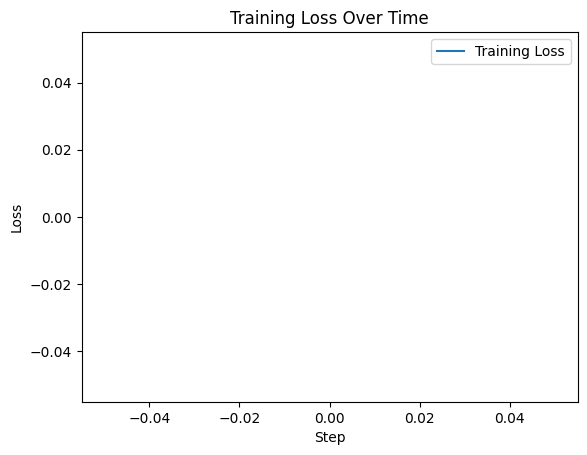

In [47]:
#Import necessary instances
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

#Train the model with all the necessary inputs
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset_train_test["train"],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 8,
    callbacks=[PlotLossesCallback()], 
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        num_train_epochs = 2,
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 20,
        save_steps=10,
        save_total_limit=3,
        #max_steps = 60,
        # Select a 2 to 10x smaller learning rate for the embedding matrices!
        learning_rate = 5e-5,
        #embedding_learning_rate = 1e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
      ),
    )

In [48]:
trainer_stats = trainer.train()

Step,Training Loss
10,0.520900
20,0.585700
30,0.541500
40,0.577800
50,0.586700
60,0.597300
70,0.543600
80,0.565700
90,0.522300
100,0.553600


/home/rmateoc/.pyenv/versions/3.11.9/envs/proy_integrador/lib/python3.11/site-packages/peft/utils/other.py:611: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: d15f65fa-e60f-4b2e-a6b5-95f1e1743c7d)') - silently ignoring the lookup for the file config.json in unsloth/mistral-7b-v0.3-bnb-4bit.
  warnings.warn(
/home/rmateoc/.pyenv/versions/3.11.9/envs/proy_integrador/lib/python3.11/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in unsloth/mistral-7b-v0.3-bnb-4bit - will assume that the vocabulary was not modified.
  warnings.warn(


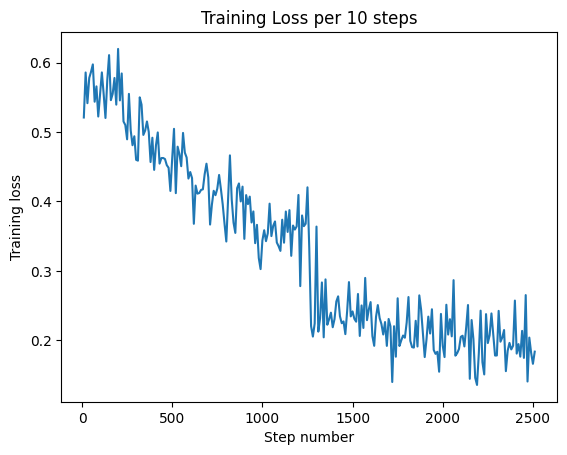

In [13]:
plot_training_loss('./outputs/training_loss_mistral_step2.json')

In [49]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

60147.353 seconds used for training.
1002.46 minutes used for training.
Peak reserved memory = 10.473 GB.
Peak reserved memory for training = 5.481 GB.
Peak reserved memory % of max memory = 67.242 %.
Peak reserved memory for training % of max memory = 35.191 %.


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [51]:
#Local Save
model.save_pretrained("unsloth-mistral-0.3-7b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2") # Local saving
tokenizer.save_pretrained("unsloth-mistral-0.3-7b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2")

#HuggingFace Save

model.push_to_hub("rafaeljosem/unsloth-mistral-0.3-7b-Instruct-bnb-4bit-8k-tok-context-Mexican-Laws-Inst-FineTuned-step2", token = os.environ.get('HF_TOKEN'))
tokenizer.push_to_hub("rafaeljosem/unsloth-mistral-0.3-7b-Instruct-bnb-4bit-8k-tok-context-Mexican-Laws-Inst-FineTuned-step2", token = os.environ.get('HF_TOKEN')) # Online saving

README.md:   0%|          | 0.00/592 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

Saved model to https://huggingface.co/rafaeljosem/unsloth-mistral-0.3-7b-Instruct-bnb-4bit-8k-tok-context-Mexican-Laws-Inst-FineTuned-step2


tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

To load the LoRA adapters previously saved for inference, set `False` to `True`:

In [82]:
if True:
    from unsloth import FastLanguageModel
    llama_3_8b_Instruct_bnb_bit_model_base, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit", # MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

#if True:
    #from unsloth import FastLanguageModel
    #model_fine_tuned, tokenizer = FastLanguageModel.from_pretrained(
        #model_name = "JonathanGarza/unsloth-llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step1", # MODEL YOU USED FOR TRAINING
        #max_seq_length = max_seq_length,
        #dtype = dtype,

        #load_in_4bit = load_in_4bit,
    #)
    #FastLanguageModel.for_inference(model) # Enable native 2x faster inference

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


adapter_config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

<a name="Inference"></a>
### Inference
Let's test some inputs from the training dataset using the base and the fine tuned model to compare the outputs

In [85]:
# alpaca_prompt = Copied from above

i = 100

print('\n\nTrain Sample:\n\n')
print(dataset_train_test['test'][i]['text'])
print('\n\n')

#1 step fine tune step model
#FastLanguageModel.for_inference(model_1step) # Enable native 2x faster inference

#inputs = tokenizer(
#[
    #alpaca_based_prompt.format(
        #dataset_train_test['test']['instruction'][i], # Instrucción
        #dataset_train_test['test']['context'][i], # Entrada
        #"", # Salida - leave this blank for generation
    #)
#], return_tensors = "pt").to("cuda")

#outputs = model_1step.generate(**inputs, max_new_tokens = 8192, use_cache = True)
#Onestep_outputs_decoded = tokenizer.batch_decode(outputs)

#print('Base model:\n\n')
#print(Onestep_outputs_decoded)

#Finetuned 1 step model
#FastLanguageModel.for_inference(model_1step) # Enable native 2x faster inference

inputs = tokenizer(
[
    alpaca_based_prompt.format(
        dataset_train_test['test']['instruction'][i], # Instrucción
        dataset_train_test['test']['context'][i], # Entrada
        "", # Salida - leave this blank for generation
    )
], return_tensors = "pt").to("cuda")

outputs_fine_tuned = model.generate(**inputs, max_new_tokens = 8192, use_cache = True)
outputs_fine_tuned_decoded = tokenizer.batch_decode(outputs_fine_tuned)

print('\n\nFine tuned model:\n\n')
print(outputs_fine_tuned_decoded)
print('\n\n')

#Base model
FastLanguageModel.for_inference(llama_3_8b_Instruct_bnb_bit_model_base) # Enable native 2x faster inference

inputs = tokenizer(
[
    alpaca_based_prompt.format(
        dataset_train_test['test']['instruction'][i], # Instrucción
        dataset_train_test['test']['context'][i], # Entrada
        "", # Salida - leave this blank for generation
    )
], return_tensors = "pt").to("cuda")

outputs = llama_3_8b_Instruct_bnb_bit_model_base.generate(**inputs, max_new_tokens = 8192, use_cache = True)
base_outputs_decoded = tokenizer.batch_decode(outputs)

print('Base model:\n\n')
print(base_outputs_decoded)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




Train Sample:


A continuación se muestra una instrucción que describe una tarea, junto con un contexto que proporciona más información. Escribe una respuesta que complete adecuadamente la instrucción

### Instrucción:
¿Qué deben hacer las dependencias y entidades de la Administración Pública Federal en relación con la Ley de Seguridad Interior?

### Contexto:
Ley de Seguridad Interior - Artículo 5. La aplicación de esta Ley corresponde al Ejecutivo Federal, a través de la Secretaría de Gobernación, con la participación de las dependencias y entidades de la Administración Pública Federal, Fuerzas Federales y, en su caso, Fuerzas Armadas, en coordinación con los otros órdenes de gobierno, en el ámbito de sus atribuciones y competencia.

### Respuesta:
Las dependencias y entidades de la Administración Pública Federal deben participar en la aplicación de la Ley de Seguridad Interior, según lo establecido en el Artículo 5 de dicha ley. Deben colaborar con el Ejecutivo Federal y la Secret

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




Fine tuned model:


['<|begin_of_text|>A continuación se muestra una instrucción que describe una tarea, junto con un contexto que proporciona más información. Escribe una respuesta que complete adecuadamente la instrucción\n\n### Instrucción:\n¿Qué deben hacer las dependencias y entidades de la Administración Pública Federal en relación con la Ley de Seguridad Interior?\n\n### Contexto:\nLey de Seguridad Interior - Artículo 5. La aplicación de esta Ley corresponde al Ejecutivo Federal, a través de la Secretaría de Gobernación, con la participación de las dependencias y entidades de la Administración Pública Federal, Fuerzas Federales y, en su caso, Fuerzas Armadas, en coordinación con los otros órdenes de gobierno, en el ámbito de sus atribuciones y competencia.\n\n### Respuesta:\nLas dependencias y entidades de la Administración Pública Federal deben participar en la aplicación de la Ley de Seguridad Interior, en coordinación con las Fuerzas Federales y Fuerzas Armadas, en el ámbit

In [76]:
llama_3_8b_Instruct_bnb_bit_model_base == model

False

<a name="Data"></a>
### Conclusions

*This new approach results in training our model taking into consideration the whole context of our dataset and not only specific instructions paired with specific outputs. The first training process results in moderate reduction in the log loss function, while the second step further refines the model to be able of answering specific requests.*

*Model evaluation will be part of a separate notebook which will use the models adjusted with this training sequences for estimating their performance*

*Further revisions are still being considered to improve the model performance in case it remains not optimal*

*After reviewing Meta Llama 3 documentation, we found a disclaimer about only around 5% of the Llama 3 pre-training data set was made up of high-quality non-English language data spanning more than 30 languages. Good performance in other languages is expected, but not on the same level as with English.*

*The impact on performance on this project due to the last remains unknow and to be determined.*

*Other hyperparameters remain to be tested in case desired performance is not achieved, including increasing from 4bit to 16-bit LoRA if current resources allow it.*

*Taking the last into consideration and depending on the evaluation results, further possible improvement opportunities include:*

1. *Using a 16-bit model instead of 8-bit.*
2. *Increasing the context window to be 8192 tokens*
3. *Using Mistral 7B with with the same training cases we have used for Llama 3 taking advantage of the fact that it was trained in several languages including spanish and is capabilty of handling 32k tokens for context window.*


*Models were successfuly loaded to HuggingFace so they are available for further testing or training for the next project deliverables.*

<a name="Data"></a>
### References

Han, D. (2023, December 1). Introducing Unsloth. Unsloth. https://unsloth.ai/introducing

Kaiokendev. (2023, June 22). Things I’m learning while training superhot. kaiokendev.github.io. https://kaiokendev.github.io/til

Hu, E. J., Shen, Y., Wallis, P., Allen-Zhu, Z., Li, Y., Wang, S., Wang, L., & Chen, W. (2021, October 16). Lora: Low-rank adaptation of large language models. arXiv.org. https://arxiv.org/abs/2106.09685

Martinez-Seis, B., Pichardo-Lagunas, O., Koff, H., Equihua, M., Perez-Maqueo, O., & Hernández-Huerta, A. (2022, July 6). Unified, labeled, and semi-structured database of pre-processed Mexican laws. MDPI. https://www.mdpi.com/2306-5729/7/7/91

Mistral AI. (2024). Models: Mistral AI large language models. Mistral AI Large Language. https://docs.mistral.ai/getting-started/models/

Nodematic Labs. (2024, April 22). Llama-3-finetune-unsloth/count-tokens.py at main · nodematiclabs/llama-3-finetune-unsloth. GitHub. https://github.com/nodematiclabs/llama-3-finetune-unsloth/blob/main/count-tokens.py

Xu, L., Xie, H., Qin, S.-Z. J., Tao, X., & Wang, F. L. (2023, December 19). Parameter-efficient fine-tuning methods for pretrained language models: A Critical Review and assessment. arXiv.org. https://arxiv.org/abs/2312.12148